In [1]:
import pandas as pd
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import umap

/tmp/ipykernel_1156060/2022224105.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 10 dims
models_dirs = {'beta_vae_1': '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/BetaVAE/2023-12-11/14-10-52/analysis/embeddings_dHCP.csv',
               'beta_vae_2': '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/BetaVAE/2023-12-18/13-54-42/analysis/embeddings_dHCP.csv',
               'beta_vae_3': '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/BetaVAE/2023-12-18/16-56-49/analysis/embeddings_dHCP.csv',
               'simclr_1': '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/15-49-36_0/dHCP_embeddings/full_embeddings.csv',
               'simclr_2': '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/15-49-36_1/dHCP_embeddings/full_embeddings.csv',
               'simclr_3': '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/15-49-36_2/dHCP_embeddings/full_embeddings.csv',
               'simclr_4': '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/09-59-38_188/dHCP_embeddings/full_embeddings.csv',
               'simclr_5': '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15/14-36-49/STs_dHCP_374_subjects_embeddings/full_embeddings.csv'}

#df_dHCP = pd.read_csv(model_dir+'/dHCP_embeddings.csv')

In [3]:
# SimCLR cingulate
# beware: for now, learning rate, batch size and input size are not fixed!!
models_dirs = {f'foldlabel_bs32_{k}': f'/volatile/jl277509/Runs/02_STS_babies/Program/Output/2024-01-30/16-44-58_{k}/ACC_embeddings/full_embeddings.csv'
               for k in range(0, 6)}
models_dirs_lr = {f'foldlabel_bs16_lr_{k}': f'/volatile/jl277509/Runs/02_STS_babies/Program/Output/2024-01-26/16-54-45_{k}/ACC_embeddings/full_embeddings.csv'
                  for k in range(0,26)}
models_dirs_trimdepth = {f'trimdepth_bs16': '/volatile/jl277509/Runs/02_STS_babies/Program/Output/2024-01-31/13-09-40_156/ACC_embeddings/full_embeddings.csv'}

models_dirs.update(models_dirs_lr)
models_dirs.update(models_dirs_trimdepth)

In [4]:
# foldlabel / cutout cingulate
# already many configs tested, still need for bug correction on bottoms (affecting keep bottom)
embeddings = '/ACC_1_embeddings/full_embeddings.csv'
models_dirs = {}
for dir_models in ['/volatile/jl277509/Runs/02_STS_babies/Program/Output/translation_only/',
                   '/volatile/jl277509/Runs/02_STS_babies/Program/Output/foldlabel/',
                   '/volatile/jl277509/Runs/02_STS_babies/Program/Output/cutout/',
                   '/volatile/jl277509/Runs/02_STS_babies/Program/Output/trimdepth/']:
    l = sorted(os.listdir(dir_models))
    for elem in l:
        models_dirs[elem]=dir_models+elem+embeddings

In [5]:
models_dirs = {}
embeddings = '/ACC_1_embeddings/full_embeddings.csv'
dir_models = '/volatile/jl277509/Runs/02_STS_babies/Program/Output/random/'
l = sorted(os.listdir(dir_models))
for elem in l:
    models_dirs[elem]=dir_models+elem+embeddings

In [6]:
## 12 layer convnet OFC
ndims=256
models_dirs = {}
embeddings = '/troiani_custom_embeddings/custom_cross_val_embeddings.csv'
dir_models_list = ['/volatile/jl277509/Runs/02_STS_babies/Program/Output/ORBITAL_12-layer_k7/',
                   '/volatile/jl277509/Runs/02_STS_babies/Program/Output/ORBITAL_12-layer_k3/']
for dir_models in dir_models_list:
    l = sorted(os.listdir(dir_models))
    for elem in l:
        models_dirs[elem]=dir_models+elem+embeddings

# Processing

In [7]:
# load embeddings
for model, directory in models_dirs.items():
    embeddings = pd.read_csv(directory)
    models_dirs[model]=embeddings

In [8]:
# peut-être vaudrait-il mieux travailler avec la mutual information. Et utiliser les représentations d'UKB ? Mais comment traduire la distribution en probabilité ? Et comment traduire une "loi jointe ?"

In [9]:
scaler = StandardScaler() # ne change pas le score de régression

In [17]:
models_embeddings = models_dirs.copy()
dims = [f'dim{k}' for k in range(1, ndims+1)]
for name, model in models_embeddings.items():
    model = model[dims].to_numpy()
    #model = scaler.fit_transform(model)
    models_embeddings[name] = model

# use linear regression

In [18]:
correl_matrix = np.zeros((len(models_dirs), len(models_dirs)))
for i, (name1, model1) in enumerate(models_embeddings.items()):
    for j, (name2, model2) in enumerate(models_embeddings.items()):
        reg = LinearRegression().fit(model1, model2)
        sc = reg.score(model1, model2)
        #print(f'{name1} {name2}: {sc}')
        correl_matrix[i,j]=sc

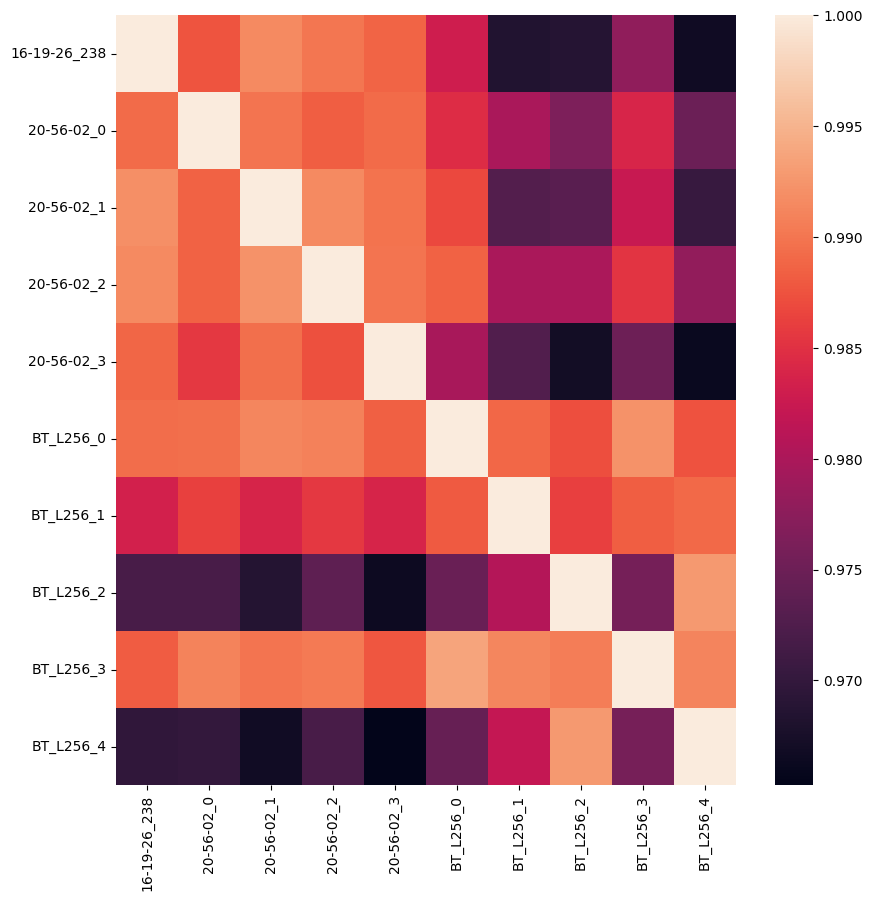

In [19]:
ticklabels = models_dirs.keys()
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(correl_matrix, annot=False, xticklabels=ticklabels, yticklabels=ticklabels,ax=ax)
plt.show()

In [16]:
convolved

array([[0.99157773, 0.97687489],
       [0.9806137 , 0.98890543]])

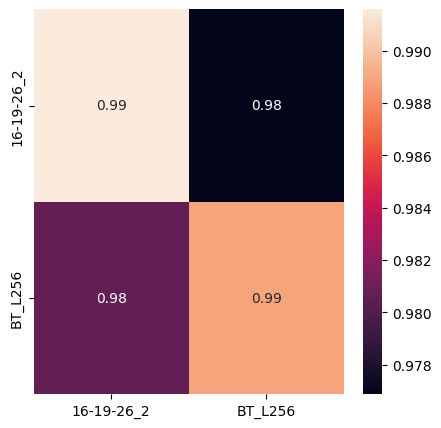

In [13]:
# convolve heatmap with step 5
# BEWARE: NEED 5 MODELS PER CONFIG. CURRENTLY LAST ONE HAS 4, WHICH REDUCES THE OBTAINED VALUE.
step=5
ticklabels = models_dirs.keys()
fig,ax=plt.subplots(figsize=(5,5))
convolved = scipy.signal.convolve2d(correl_matrix, np.ones((5,5)))[4::5,4::5] / 25
labels = list(ticklabels)[::step]
labels = [elem[:-2] for elem in labels]
sns.heatmap(convolved, annot=True, xticklabels=labels, yticklabels=labels, ax=ax)
plt.show()

# Use disimilarity matrix (pairwise euclidean distance)
Beware: the metric is asymmetric, maybe average ?
Use euclidean or cosine distance ? euclidean for betavae and cosine for simclr ?

In [14]:
# compute pairwise euclidean distance between all subjects and select a restricted neighborhood
proportion = 0.2
nb_subjects = models_embeddings[list(models_embeddings.keys())[0]].shape[0]
nb_neigh = int(nb_subjects * proportion)
nb_models = len(models_embeddings.keys())
tau_mat, p_value_mat = np.zeros((nb_models, nb_models)), np.zeros((nb_models, nb_models))

for i, (name1, model1) in enumerate(models_embeddings.items()):
    for j, (name2, model2) in enumerate(models_embeddings.items()):

        selected_dists_1 = []
        selected_dists_2 = []
        pairwise_dists_1 = euclidean_distances(model1)
        #pairwise_dists_1 = cosine_similarity(model1)
        pairwise_dists_2 = euclidean_distances(model2)
        #pairwise_dists_2 = cosine_similarity(model2)
        for idx, (dists_1, dists_2) in enumerate(zip(pairwise_dists_1, pairwise_dists_2)):
            dists_1 = np.delete(dists_1, idx) #remove distance to itself
            dists_2 = np.delete(dists_2, idx)
            idxs=np.argsort(dists_1) #get closest subjects for model1
            selected_dists_1=selected_dists_1+dists_1[idxs[:nb_neigh]].tolist()
            selected_dists_2=selected_dists_2+dists_2[idxs[:nb_neigh]].tolist() #apply same subject selection to model2
        tau, p = scipy.stats.kendalltau(selected_dists_1, selected_dists_2)
        tau_mat[i,j]=tau
        p_value_mat[i,j]=p

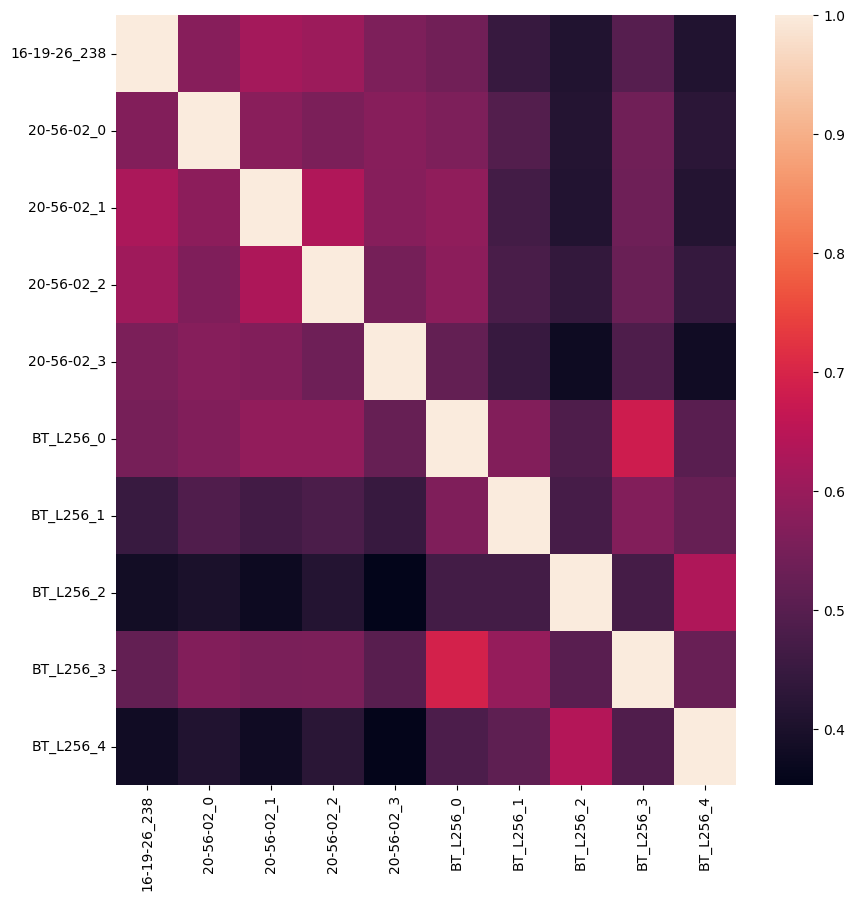

In [15]:
ticklabels = models_dirs.keys()
#fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(tau_mat, annot=False, xticklabels=ticklabels, yticklabels=ticklabels,ax=ax)
#sns.heatmap(p_value_mat, annot=True, xticklabels=ticklabels, yticklabels=ticklabels, ax=axs[1])
plt.show()

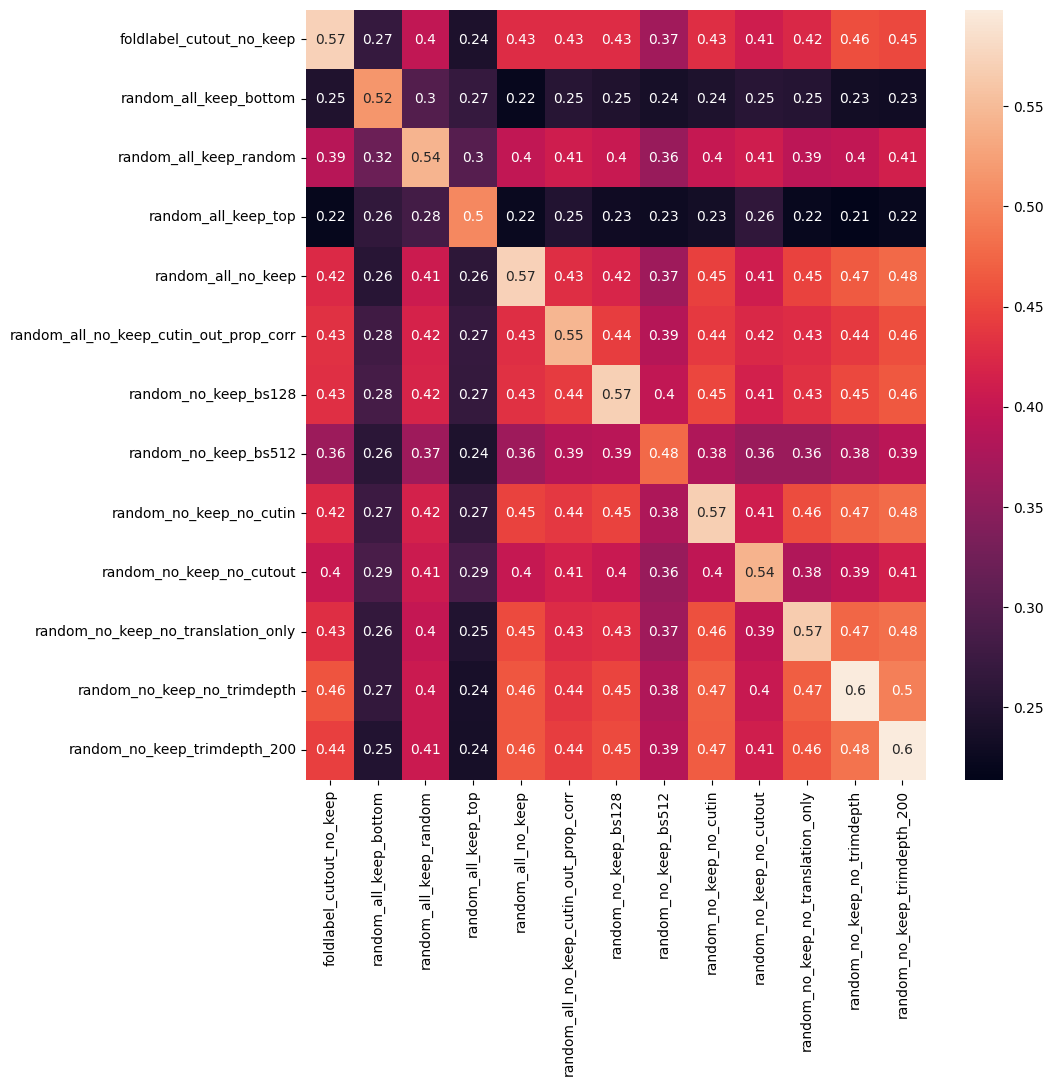

In [14]:
# convolve heatmap with step 5
# BEWARE: NEED 5 MODELS PER CONFIG. CURRENTLY LAST ONE HAS 4, WHICH REDUCES THE OBTAINED VALUE.
step=5
ticklabels = models_dirs.keys()
fig,ax=plt.subplots(figsize=(10,10))
convolved = scipy.signal.convolve2d(tau_mat, np.ones((5,5)))[4::5,4::5] / 25
labels = list(ticklabels)[::step]
labels = [elem[:-2] for elem in labels]
sns.heatmap(convolved, annot=True, xticklabels=labels, yticklabels=labels, ax=ax)
plt.show()

# COMPARISON TO MORPHOMETRY

In [5]:
mods = {'B-VAE': [],
        'SimCLR': [],
        'morpho all': [],
        'morpho shape': [],
        'morpho pos': []}

sulci = ['S.T.s', 'CINGULATE']
sides = ['left', 'right']

models = {sulcus+'_'+side: mods for sulcus in sulci for side in sides}

In [52]:
# select morpho rows based on info dHCP and simple morpho to get measures corresponding to right sessions
# done only once to define the indexes to keep
info_dHCP = pd.read_csv('/neurospin/dico/jlaval/data/info_dHCP.csv')
sulcus = 'S.T.s._right'
morpho_params = ['hull_junction_length_talairach', 'maxdepth_talairach', 'GM_thickness', 'opening', 'meandepth_talairach', 'surface_talairach']
morpho_df = pd.DataFrame(columns=morpho_params)

for idx, (id, session, _, _) in info_dHCP.iterrows():
    morpho_dir = f'/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_morpho_bids/sub-{id}/ses-{session}/anat/t1mri/default_acquisition/default_analysis/folds/3.1/default_session_auto/{id}_default_session_auto_sulcal_morphometry.csv'
    morpho = pd.read_csv(morpho_dir, sep=';')
    morpho_sulcus = morpho.loc[morpho['sulcus']==sulcus][morpho_params]
    morpho_df = morpho_df.append(morpho_sulcus)

df_morpho = pd.concat([info_dHCP, morpho_df.set_index(info_dHCP.index)], axis=1)

for idx, row in morpho.iterrows():
    if df_morpho.loc[df_morpho['participant_id']==row['subject']].shape[0]==0:
        morpho.drop(idx, inplace=True)
    elif row['hullJunctionsLength'] != df_morpho.loc[df_morpho['participant_id']==row['subject']].hull_junction_length_talairach.tolist()[0]:
        morpho.drop(idx, inplace=True)

index_to_keep = morpho.index.tolist()

KeyError: 'subject'

In [54]:
# compute and return 3 dfs
def format_morpho(df):

    length = df['hullJunctionsLength'].to_numpy()
    extremity1 = df[['extremity1x', 'extremity1y', 'extremity1z']].to_numpy()
    extremity2 = df[['extremity2x', 'extremity2y', 'extremity2z']].to_numpy()
    coords = extremity1-extremity2
    d = np.sqrt(np.square(coords[:,0]) + np.square(coords[:,1]) + np.square(coords[:,2]))

    foldness = (length - d) / length

    df['SulcusLength']=d # probably not used ?
    df['foldness']=foldness

    # first positional measures
    posi_params = ['gravityCenter_x', 'gravityCenter_y', 'gravityCenter_z',
                'normal_x', 'normal_y', 'normal_z',
                'direction_x', 'direction_y', 'direction_z']

    cols = [f'dim{k}' for k in range(1,len(posi_params)+1)]
    embeddings_pos = df[['subject']+posi_params]
    embeddings_pos.columns=['ID']+cols

    shape_params = ['surface', 'geodesicDepthMax', 'geodesicDepthMean', 'hullJunctionsLength',
                'connectedComponentsAllRels', 'connectedComponents', 'foldness']


    cols = [f'dim{k}' for k in range(1,len(shape_params)+1)]

    embeddings_shape = df[['subject']+shape_params]
    embeddings_shape.columns=['ID']+cols

    all_params = posi_params + shape_params

    cols = [f'dim{k}' for k in range(1,len(all_params)+1)]

    embeddings_all = df[['subject']+all_params]
    embeddings_all.to_csv('/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/morpho_labels.csv', index=False)
    embeddings_all.columns=['ID']+cols

    return(embeddings_all, embeddings_shape, embeddings_pos)

In [60]:
# load embeddings of each model
sulci = ['S.T.s'] # temporary...
sides = ['right']

#S.T.s_left
models['S.T.s_right']['B-VAE'] = pd.read_csv('/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/BetaVAE/2023-12-11/14-10-52/analysis/embeddings_dHCP.csv')
models['S.T.s_right']['SimCLR'] = pd.read_csv('/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/09-59-38_188/dHCP_embeddings/full_embeddings.csv')

# morpho
for sulcus in sulci:
    for side in sides:
        morpho = pd.read_csv(f'/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/morphometry/morphometry_statistics/right/morpho_{sulcus}._{side}.dat', sep=' ')
        morpho = morpho.loc[index_to_keep]
        morphos = format_morpho(morpho)
        models[f'{sulcus}_{side}']['morpho all'], models[f'{sulcus}_{side}']['morpho shape'], models[f'{sulcus}_{side}']['morpho pos'] = morphos[0], morphos[1], morphos[2]

In [122]:
def dist_embeddings(df1, df2, dist1='euclidean', dist2='euclidean', nb_neigh=-1):

    """
    Returns disymilarity between two embeddings using rank test on pairwise distances
    """

    # then select all subjects
    if nb_neigh == -1:
        nb_neigh = df1.shape[0]-1

    model1 = df1.drop('ID', axis=1).to_numpy()
    model2 = df2.drop('ID', axis=1).to_numpy()

    model1 = scaler.fit_transform(model1)
    model2 = scaler.fit_transform(model2)

    selected_dists_1 = []
    selected_dists_2 = []
    
    if dist1=='euclidean':
        pairwise_dists_1 = euclidean_distances(model1)
    elif dist1=='cosine':
        pairwise_dists_1 = cosine_similarity(model1)
    if dist2=='euclidean':
        pairwise_dists_2 = euclidean_distances(model2)
    elif dist2=='cosine':
        pairwise_dists_2 = cosine_similarity(model2)

    for dists_1, dists_2 in zip(pairwise_dists_1, pairwise_dists_2):
        dists_1 = np.delete(dists_1, 0) #remove distance to itself
        dists_2 = np.delete(dists_2, 0)
        idxs=np.argsort(dists_1) #get closest subjects for model1
        selected_dists_1=selected_dists_1+dists_1[idxs[:nb_neigh]].tolist()
        selected_dists_2=selected_dists_2+dists_2[idxs[:nb_neigh]].tolist() #apply same subject selection to model2
    print(selected_dists_1)
    tau, p = scipy.stats.kendalltau(selected_dists_1, selected_dists_2)
    
    return(tau, p)

In [18]:
# y a-t-il des nans ? Récupérer les index pour supprimer les sujets avant de faire les calculs de distances pairwise...

In [228]:
df1 = models['S.T.s_right']['SimCLR']
df2 = models['S.T.s_right']['morpho all']
dist1='euclidean'
dist2='euclidean'
nb_neigh=-1

# then select all subjects
if nb_neigh == -1:
    nb_neigh = df1.shape[0]-1

model1 = df1.drop('ID', axis=1).to_numpy()
model2 = df2.drop('ID', axis=1).to_numpy()

model1 = scaler.fit_transform(model1)
model2 = scaler.fit_transform(model2)

selected_dists_1 = []
selected_dists_2 = []

if dist1=='euclidean':
    pairwise_dists_1 = euclidean_distances(model1)
elif dist1=='cosine':
    pairwise_dists_1 = cosine_similarity(model1)
if dist2=='euclidean':
    pairwise_dists_2 = euclidean_distances(model2)
elif dist2=='cosine':
    pairwise_dists_2 = cosine_similarity(model2)

for idx, (dists_1, dists_2) in enumerate(zip(pairwise_dists_1, pairwise_dists_2)):
    dists_1 = np.delete(dists_1, idx) #remove distance to itself
    dists_2 = np.delete(dists_2, idx)
    idxs=np.argsort(dists_1) #get closest subjects for model1
    selected_dists_1=selected_dists_1+dists_1[idxs[:nb_neigh]].tolist()
    selected_dists_2=selected_dists_2+dists_2[idxs[:nb_neigh]].tolist() #apply same subject selection to model2
tau, p = scipy.stats.kendalltau(selected_dists_1, selected_dists_2)
print(tau)